Natural Language Processing Tutorial
======

This is the tutorial of the 2023 [Mediterranean Machine Learning Summer School](https://www.m2lschool.org/) on Natural Language Processing!

This tutorial will explore the fundamental aspects of Natural Language Processing (NLP). Whether you are new to NLP or just beginning your journey, there's no need to worry, as the tutorial assumes minimal prior knowledge. Our focus will be on implementing everything from scratch to ensure clarity and understanding. To facilitate this, we will be using [JAX](https://jax.readthedocs.io/en/latest/), a library that offers an API similar to Numpy (and often identical) with the added benefit of automatic differentiation.

## Outline

- 0 Refresher on JAX, Haiku and Optax
- 1 Introduction to NLP
  - 1.1 The NLP pipeline
  - 1.2 Classification pipeline: Multi-hot encoding + MLP model
  - 1.3 Classification pipeline: Embeddings + Sequential Model
- <span style="color:blue">2 Introduction to the Transformers architecture </span>
  - <span style="color:blue">2.1 Transformer architecture </span>
  - <span style="color:blue">2.2 Implementing the core components </span>
  - <span style="color:blue">2.3 Transformer for classification pipeline </span>
- 3 Continuing Transformers: Decoder and the complete architecture
  - 3.1 The Transformer Decoder
  - 3.2 Transformer Decoder for character-based Language Modelling
  - 3.3 The full Transformer
  - 3.4 Transformer for Neural Machine Translation

## Emojis

Sections marked as [ 📝 ] contain cells with missing code that you should complete [ &#x1F4C4; ] is used for links to interesting external resources. When we use the words of an external resource we will cite it with &#x1F449; resource &#x1F448;.

## Libraries

We will keep our promise that (almost &#x1F60B; ) everything will be built from scratch. Indeed, all the vital and challenging components will be developed from zero. In fact the whole tutorial could be done only based on JAX. However, we recognize that certain minor technical details can become distracting if much time spent for them. For these tiny bits, we will ask help from [haiku](https://dm-haiku.readthedocs.io/en/latest/) to code neural network architectures, [optax](https://optax.readthedocs.io/en/latest/) to bring us the optimal parameters and [tokenizers](https://huggingface.co/docs/tokenizers/index) to quickly learning the vocabulary in each dataset. And the ubiquitous [numpy](https://numpy.org/) and [pandas](https://pandas.pydata.org/) for tensor handling. That's all!

It would be also nice, if you have access to GPU! And hopefully due to google colab you can immediately access a cudas-enabled environment pressing the the button below.

## Credits

The tutorial is created by [Vasilis Gkolemis](https://givasile.github.io/) and [Matko Bošnjak](https://matko.info). It is highly inspired by [Deep Learning with Python (DLP)](https://www.manning.com/books/deep-learning-with-python) the famous book of Francois Chollet, last year's [M2Lschool](https://github.com/M2Lschool/tutorials2022) NLP tutorial especially for the transformers part, the [annotated transformer](http://nlp.seas.harvard.edu/annotated-transformer/) presentation

## Note for Colab users

To grab a GPU (if available), make sure you go to `Edit -> Notebook settings` and choose a GPU under `Hardware accelerator`

## Practical 3

Welcome to Practical 3 where we will continue deeper into the Transformer architecture. Previously, we've made a Transformer Encoder for classification. We've still got the Transformer Decoder outstanding before we can connect these two together into the complete Transformer architecture.

In this practical, we will do two concrete things:
- first, we will code the Transformer Decoder and apply it to the character-based language modelling task
- second, we will connect the Encoder and the Decoder into the complete Transformer architecture and train an English to Greek Neural Machine Translator.

The key aim of this session is to attain a comprehensive understanding of the Transformer Decoder, the full Transformer architecture and the Neural Machine Translation task. We will continue with our practice of coding everything up from scratch, but ensuring that we reuse the previously built components.

---

Let's run the following cells to ensure all our libraries and imports are set up...

In [ ]:
#@title Libraries and imports
!pip install dm-haiku optax tokenizers datasets scikit-learn

import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpy as np
import pandas as pd
import tokenizers
import os
import typing
from sklearn.model_selection import train_test_split
import collections
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

from datasets import Dataset, DatasetDict, load_dataset
from torch.utils.data import DataLoader

# forces JAX to allocate memory as needed
# see https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

def jax_has_gpu():
    try:
        _ = jax.device_put(jax.numpy.ones(1), device=jax.devices('gpu')[0])
        return True
    except:
        return False

gpu = jax_has_gpu()   # automatically checks for gpus, override if needed.

# haiku provides a nice helper for returning a seed generator
init_seed = 21
prng_key = jax.random.PRNGKey(init_seed)
rng_iter = hk.PRNGSequence(prng_key)
key = prng_key

We start first by reusing what we've built in Practical 2, namely the following functions and classes:
- `scaled_dot_product`
- `MultiheadAttention`
- `PositionwiseFeedForward`
- `PositionalEncoding`
- `EncoderBlock`
- `TransformerEncoder`

Do copy your code for these functions from your previous practical.

In [ ]:
#@title Prerequisite code from the previous practical

def scaled_dot_product(q, k, v, mask=None):
    """
    Apply the Scaled Dot Product Attention.

    Args:
        q (jnp.ndarray): query, shape (batch_size, ..., hidden_dim)
        k (jnp.ndarray): key, shape (batch_size, ..., hidden_dim)
        v (jnp.ndarray): values, shape (batch_size, ..., hidden_dim)
        mask (jnp.ndarray): values, shape (broadcastable to: B,...,S,S)

    Returns:
        List(jnp.ndarray, jnp.ndarray): attention output (batch_size, ..., S), attention_weights (batch_size, ..., S, S)
    """
    ###################
    # YOUR CODE HERE #
    d_k = q.shape[-1]
    scores = jnp.matmul(q, k.swapaxes(-2, -1)) / jnp.sqrt(d_k)  # (B,...,S,S)

    if mask is not None:
        scores = jnp.where(mask == 0, -1e9, scores)

    attention_weights = jax.nn.softmax(scores, axis=-1)
    values = jnp.matmul(attention_weights, v)
    # Steps:
    # (i) tensor multiplication between q, k to get the scores
    # (ii) if mask is not None, set the scores of masked out values a very small value
    # (iii) softmax the scores to get attention weights
    # (iv) tensor multiplication between attention_weights and values to get values
    ###################
    return values, attention_weights

class MultiheadAttention(hk.Module):
    def __init__(self, d_model: int, num_heads: int, name=None):
        """
        Multi-Headed Attention Module.

        Args:
            d_model (int): The dimension of the model, which should be divisible by num_heads.
            num_heads (int): The number of attention heads.
            name (str): Optional name of the module.
        """
        super().__init__(name=name)
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = self.d_model // self.num_heads
        self.lin_projs = [hk.Linear(self.d_model) for _ in range(num_heads)]

    def __call__(self, q, k, v, mask=None):
        """
        Apply Multi-Headed Attention.

        Args:
            q (jnp.ndarray): Query tensor with shape (batch_size, sequence_length, d_model).
            k (jnp.ndarray): Key tensor with shape (batch_size, sequence_length, d_model).
            v (jnp.ndarray): Value tensor with shape (batch_size, sequence_length, d_model).
            mask (jnp.ndarray): Mask tensor with shape (batch_size, sequence_length) representing valid elements in the input sequences.

        Returns:
            jnp.ndarray: Output tensor after multi-headed attention with shape (batch_size, sequence_length, d_model).
            jnp.ndarray: Attention weights tensor with shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        ###################
        # YOUR CODE HERE #
        batch_size, seq_length, d_model = q.shape

        # Reshape q, k, v
        q, k, v = [
            lin_p(t).reshape(batch_size, -1, self.num_heads, self.d_k).swapaxes(1, 2)
            for lin_p, t in zip(self.lin_projs, (q, k, v))
        ]  # (B,h,S,d_k)

        if mask is not None:
            mask = jnp.expand_dims(mask, 1)  # expand to (B,h,...)

        values, attention = scaled_dot_product(q, k, v, mask=mask)  # (B,h,S,d_k)
        values = values.transpose(0, 2, 1, 3)
        values = values.reshape(batch_size, seq_length, d_model)  # concat heads
        y = self.lin_projs[-1](values), attention
        ###################
        return y


class PositionwiseFeedForward(hk.Module):
    """
    This class is used to create a position-wise feed-forward network.

    Args:
        d_model (int): The size of the embedding vector.
        d_ff (int): The size of the hidden layer.
        p_dropout (float, optional): The dropout probability. Default is 0.1.
    """
    def __init__(self, d_model: int, d_ff: int, p_dropout: float = 0.1, name=None):
        super().__init__(name=name)
        self.d_model = d_model
        self.d_ff = d_ff
        self.p_dropout = p_dropout

        self.w_1 = hk.Linear(self.d_ff)
        self.w_2 = hk.Linear(self.d_model)

    def __call__(self, x, is_train=True):
        """
        Apply the position-wise feed-forward network.

        Args:
            x (jnp.ndarray): The input sequence with shape (batch_size, sequence_length, d_model).
            is_train (bool, optional): Whether the model is in training mode. Default is True.

        Returns:
            jnp.ndarray: The output of the position-wise feed-forward network with shape (batch_size, sequence_length, d_model).
        """
        ###################
        # YOUR CODE HERE #
        x = jax.nn.relu(self.w_1(x))
        if is_train:
            x = hk.dropout(hk.next_rng_key(), self.p_dropout, x)

        y = self.w_2(x)
        ###################
        return y

class EncoderBlock(hk.Module):
    """
    This class is used to create an encoder block.

    Args:
        d_model (int): The size of the embedding vector.
        num_heads (int): The number of attention heads.
        d_ff (int): The size of the hidden layer.
        p_dropout (float): The dropout probability.
    """
    def __init__(self, d_model, num_heads, d_ff, p_dropout, name=None):
        super().__init__(name=name)
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.p_dropout = p_dropout

        # self-attention sub-layer
        self.self_attn = MultiheadAttention(
            d_model=self.d_model, num_heads=self.num_heads
        )
        # positionwise feedforward sub-layer
        self.ff = PositionwiseFeedForward(
            d_model=self.d_model, d_ff=self.d_ff, p_dropout=self.p_dropout
        )

        self.norm1 = hk.LayerNorm(
            axis=-1, param_axis=-1, create_scale=True, create_offset=True
        )
        self.norm2 = hk.LayerNorm(
            axis=-1, param_axis=-1, create_scale=True, create_offset=True
        )

    def __call__(self, x, mask=None, is_train=True):
        """
        Apply the encoder block to the input sequence.

        Args:
            x (jnp.ndarray): The input sequence with shape (batch_size, sequence_length, d_model).
            mask (jnp.ndarray, optional): The mask to be applied to the self-attention layer with shape (batch_size, sequence_length). Default is None.
            is_train (bool, optional): Whether the model is in training mode. Default is True.

        Returns:
            jnp.ndarray: The output of the encoder block, which is the updated input sequence with shape (batch_size, sequence_length, d_model).
        """
        d_rate = self.p_dropout if is_train else 0.0

        # attention sub-layer
        sub_x, _ = self.self_attn(x, x, x, mask=mask)
        if is_train:
            sub_x = hk.dropout(hk.next_rng_key(), self.p_dropout, sub_x)
        x = self.norm1(x + sub_x)  # residual conn

        # feedforward sub-layer
        sub_x = self.ff(x, is_train=is_train)
        if is_train:
            sub_x = hk.dropout(hk.next_rng_key(), self.p_dropout, sub_x)
        x = self.norm2(x + sub_x)  # sub_x

        return x

class TransformerEncoder(hk.Module):
    """
    This class is used to create a transformer encoder.
    :param num_layers: The number of encoder blocks.
    :param num_heads: The number of attention heads.
    :param d_model: The size of the embedding vector.
    :param d_ff: The size of the hidden layer.
    :param p_dropout: The dropout probability.
    """

    def __init__(self, num_layers, num_heads, d_model, d_ff, p_dropout, name=None):
        super().__init__(name=name)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_ff = d_ff
        self.p_dropout = p_dropout

        self.layers = [
            EncoderBlock(self.d_model, self.num_heads, self.d_ff, self.p_dropout)
            for _ in range(self.num_layers)
        ]

    def __call__(self, x: typing.List[int], mask=None, is_train=True):
        """
        It applies the transformer encoder to the input sequence.
        :param x: The input sequence.
        :param mask: The mask to be applied to the self-attention layer.
        :param is_train: Whether the model is in training mode.
        :return: The final output of the encoder that contains the last encoder block output.
        """
        for l in self.layers:
            x = l(x, mask=mask, is_train=is_train)
        return x

class PositionalEncoding(hk.Module):
    """
    This class is used to add positional encoding to the input sequence.

    Args:
        d_model (int): The size of the embedding vector.
        max_len (int): The maximum length of the input sequence.
        p_dropout (float, optional): The dropout probability. Default is 0.1.
    """

    def __init__(self, d_model: int, max_len: int, p_dropout: float = 0.1, name=None):
        """
        Initialize PositionalEncoding module.

        Args:
            d_model (int): The size of the embedding vector.
            max_len (int): The maximum length of the input sequence.
            p_dropout (float, optional): The dropout probability. Default is 0.1.
        """
        super().__init__(name=name)
        self.d_model = d_model
        self.max_len = max_len
        self.p_dropout = p_dropout

        pe = jnp.zeros((self.max_len, self.d_model))
        position = jnp.arange(0, self.max_len, dtype=jnp.float32)[:, None]
        div_term = jnp.exp(jnp.arange(0, self.d_model, 2) * (-jnp.log(10000.0) / self.d_model))
        pe.at[:, 0::2].set(jnp.sin(position * div_term))
        pe.at[:, 1::2].set(jnp.cos(position * div_term))
        pe = pe[None]
        self.pe = jax.device_put(pe)

    def __call__(self, x, is_train=True):
        """
        Apply positional encoding to the input sequence.

        Args:
            x (jnp.ndarray): The input sequence with shape (batch_size, sequence_length, d_model).
            is_train (bool, optional): Whether the model is in training mode. Default is True.

        Returns:
            jnp.ndarray: The input sequence with positional encoding.
        """
        x = x + self.pe[:, : x.shape[1]]
        if is_train:
            return hk.dropout(hk.next_rng_key(), self.p_dropout, x)
        else:
            return x


# 3 Continuing Transformers: Decoder and the complete architecture

To wrap up the complete Transformer architecture, we need to code up the decoder and connect it with the encoder.

We will code up the decoder separately, and use it for an opportunity to showcase how a standalone Transformer Decoder can be used for language modelling.

Afterwards, we will connect the encoder and the decoder in order to create a Neural Machine Translator.

### 3.1 The Transformer Decoder

Similarly to the Transformer Encoder, the Transformer Decoder is a stack of identical blocks we will call `DecoderBlock`. See the relation between the encoder and the decoder in the figure below.

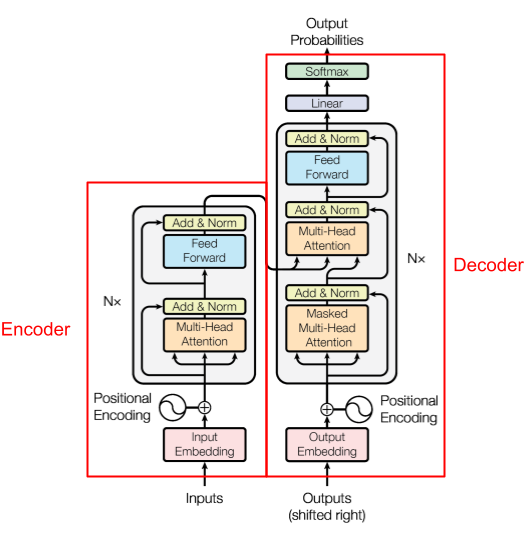

#### [ 📝 ] (Simple) Decoder Block

A single Decoder Block is defined as:
1. a (masked) Multi-Head Attention layer. Masked is there to enable the model to generate texts autoregressively and we will describe this it more detail later.

2. SKIPPING! The decoder contains a cross-attention layer here which we will omit in our decoder as we will use it for language modelling where we do not need the cross-attention
3. a position-wise feed-forward layer
4. skip connections and layer-normalization

This decoder block is depicted in the figure below:

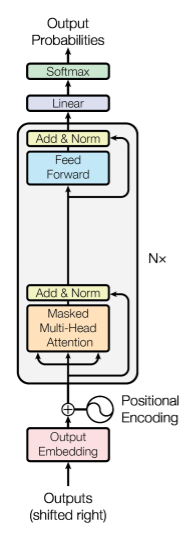

Let's turn this into code. Since later we will be using the full `DecoderBlock` we will dub our current Decoder Block the `SimpleDecoderBlock`:


In [ ]:
class SimpleDecoderBlock(hk.Module):
    """This class is used to create a decoder block.

    Args:
        d_model (int): The size of the embedding vector.
        num_heads (int): The number of attention heads.
        d_ff (int): The size of the hidden layer.
        p_dropout (float): The dropout probability.
    """
    def __init__(self, d_model, num_heads, d_ff, p_dropout, name=None):
        super().__init__(name=name)
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.p_dropout = p_dropout

        # self-attention sub-layer
        self.self_attn = MultiheadAttention(
            d_model=self.d_model, num_heads=self.num_heads
        )

        # note again, we are NOT using a cross-attention module here

        # positionwise feedforward sub-layer
        self.ff = PositionwiseFeedForward(
            d_model=self.d_model, d_ff=self.d_ff, p_dropout=self.p_dropout
        )
        self.norm1 = hk.LayerNorm(
            axis=-1, param_axis=-1, create_scale=True, create_offset=True
        )
        self.norm2 = hk.LayerNorm(
            axis=-1, param_axis=-1, create_scale=True, create_offset=True
        )

    def __call__(self, x, mask=None, is_train=True):
        """Apply the decoder block to the input sequence and the encoder_state.

        Args:
            x (jnp.ndarray): The input sequence with
              shape (batch_size, sequence_length, d_model).
            mask (jnp.ndarray, optional): The mask to be applied to the
              self-attention layer with shape (batch_size, sequence_length).
              Default is None.
            is_train (bool, optional): Whether the model is in training mode.
            Default is True.

        Returns:
            jnp.ndarray: The output of the encoder block, which is the updated
            input sequence with shape (batch_size, sequence_length, d_model).
        """

        ##################
        # YOUR CODE HERE #

        # self-attention sub-layer
        sub_x, _ = self.self_attn(x, x, x, mask=mask)
        if is_train:  # dropout layer
            sub_x = hk.dropout(hk.next_rng_key(), self.p_dropout, sub_x)
        x = self.norm1(x + sub_x)  # add (residual connection) & norm

        # feedforward sub-layer
        sub_x = self.ff(x, is_train=is_train)
        if is_train:
            sub_x = hk.dropout(hk.next_rng_key(), self.p_dropout, sub_x)
        x = self.norm2(x + sub_x)

        # (i) Call the self-attention (pass it the target_mask), apply dropout, a skip-connection and a layer-norm
        # (ii) DO NOT call the cross-attention now
        # (iii) Call the feed-forward layer, apply the dropout, a skip-connection and a layer-norm
        # (iv) return the output
        ##################

        return x


#### [ 📝 ] (Simple) Transformer Decoder

Let's move on to the `SimpleTransformerDecoder` which is simply composed of multiple *decoder blocks*. `Simple` differentiates this model from the later `TransformerDecoder` as it is not using the cross-attention, as it should.

The `SimpleTransformerDecoder` class implements it by stacking $N$ `SimpleDecoderBlock`s, where $N$ is the number of stacked blocks.

This class inputs the same set of parameters as the `SimpleDecoderBlock` class and adds the parameter `num_layers` to specify the number of stacked encoder blocks.

In [ ]:
class SimpleTransformerDecoder(hk.Module):
    """The Transformer decoder (a stack of DecoderBlocks).

    Args:
        num_layers: The number of encoder blocks.
        num_heads: The number of attention heads.
        d_model: The size of the embedding vector.
        d_ff: The size of the hidden layer.
        p_dropout: The dropout probability.
    """

    def __init__(self, num_layers, num_heads, d_model, d_ff, p_dropout, name=None):
        super().__init__(name=name)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_ff = d_ff
        self.p_dropout = p_dropout

        self.layers = [
            SimpleDecoderBlock(self.d_model, self.num_heads,
                               self.d_ff, self.p_dropout)
            for _ in range(self.num_layers)
        ]


    def __call__(self, x, mask=None, is_train=True):
        """
        Apply the decoder to the input sequence.

        Args:
            x (jnp.ndarray): The input sequence with
              shape (batch_size, sequence_length, d_model).
            mask (jnp.ndarray, optional): The mask to be applied to the
              self-attention layer with shape (batch_size, sequence_length).
              Default is None.
            is_train (bool, optional): Whether the model is in training mode.
              Default is True.

        Returns:
            jnp.ndarray: The output of the transformer decoder, which is a
              successively updated input sequence with
              shape (batch_size, sequence_length, d_model).
        """
        ##################
        # YOUR CODE HERE #
        for l in self.layers:
            x = l(x, mask, is_train)
        # (i) pass the inputs through all the layers defined in the init
        # (ii) return the output value
        ##################
        return x

#### Embedding Layer

We will also use the `Embeddings` class that creates a trainable embedding matrix for a given vocabulary size.

In [ ]:
class Embeddings(hk.Module):
    """Creates an embedding matrix for a given vocabulary size.

    Args:
        d_model: The size of the embedding vector.
        vocab_size: The size of the vocabulary.
    """
    def __init__(self, d_model, vocab_size, name=None):
        super().__init__(name=name)
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embeddings = hk.Embed(self.vocab_size, self.d_model)

    def __call__(self, x):
        """
        Args:
            x: The input sequence.
        Returns:
            The embedding matrix.
        """
        return self.embeddings(x) * jnp.sqrt(self.d_model)

#### [ 📝 ] Causal masking

Let's create a `casual_mask` function to create a __causal__ or __autoregressive__ mask for the model. Specifically, when predicting any value, the unmasked transformer uses all the available information for the prediction. However, when we want to predict text autoregressively, we need to make sure that when predicting the k-th token, the model should only attend to the preceeding k-1 tokens. If we don't do that and let the model use all tokens, the attention would 'peek into the future' tokens, which it certainly should not.

We do that by employing causal masking, which is structured to instruct the model to:
- use only the first token to predict the second one
- use only the first two tokens to predict the third one
...
- use only the k-th token to predict the k+1-th

When we code this up as a causal masking matrix, for a sequence of length 4, we get:


<center>$\begin{bmatrix}1 & 0 & 0 & 0 \\1 & 1 & 0 & 0 \\ 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 \end{bmatrix}$</center>

Now code this up for the general case:

In [ ]:
def causal_mask(S: int):
    """Causal masking for the Transformer which masks out subsequent positions.

    Given an integer `S`, generate a `1xSxS` matrix containing the attention
    mask to apply to the sequence in order to force the transformer to just pay
    attention to the previous tokens.
    The matrix should implement the autoregressive attention
    (left-context attention), i.e., it should mask, for each token at
    position 'i', every token in [0, 'i'-1).

    E.g.

    MAX_LEN = 8
    SEQ_LEN = 5

    Encoder attention mask:

    [ [1, 1, 1, 1, 1, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 0, 0, 0, ] ]

    Decoder attention mask:

    [ [1, 0, 0, 0, 0, 0, 0, 0, ]
    [1, 1, 0, 0, 0, 0, 0, 0, ]
    [1, 1, 1, 0, 0, 0, 0, 0, ]
    [1, 1, 1, 1, 0, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 0, 0, 0, ]
    [1, 1, 1, 1, 1, 1, 0, 0, ]
    [1, 1, 1, 1, 1, 1, 1, 0, ]
    [1, 1, 1, 1, 1, 1, 1, 1, ] ]
    """

    ##################
    # YOUR CODE HERE #
    mask = jnp.tril(jnp.ones((1, S, S))).astype(jnp.uint8)
    # (i) create the causal/autoregressive mask.
    #     Hint: it's a single linear algebra operation
    ##################
    return mask

### 3.2 Transformer Decoder for character-based Language Modelling

The Transformer Decoder is an excellent fit for language models that predict the next token in a sequence, be it a character, a word or a sub-word token.
The task of character-based language model is to predict the next character given a sequence of previous characters. We can do that with a *self-supervised* objective: given a sequence of characters, we need to predict the next characters, effectively the input shifted by 1 to the left. We do not need other supervision than the text itself.



One note when it comes to next token language modelling: these language models are basically a huge Transformer Decoder only, as they are well fit to decode a given context (the observed words) into the subsequent token, without the need to attend to anything else. Notable models of this class are GPT-x, OPT and BLOOM models.


With the Transformer Decoder class now ready, we can take our time to go through all the required steps in preparation for the actual training. Now we need to:
1. pick a dataset. We just need an unlabelled corpus of texts.
3. preprocess our corpus with a simple character tokenizer

In [ ]:
# first, our hyperparam set
BATCH_SIZE = 64
NUM_LAYERS = 6
NUM_HEADS = 4
D_MODEL = 256
D_FF = 256
P_DROPOUT = 0.1
MAX_SEQ_LEN = 32
LEARNING_RATE = 3e-4
EPOCHS = 5

#### Dataset selection

Since for this task we just need a bulk of text, we'll use
[The Complete Works of William Shakespeare](https://www.gutenberg.org/ebooks/100) from [Project Gutenberg](https://www.gutenberg.org/), a library of over 70k free books.

The goal here is to demonstrate the training of a language model and not to break any particular performance records.

In [ ]:
!wget "http://www.gutenberg.org/files/100/100-0.txt"

with open('100-0.txt', 'r', encoding='utf-8-sig') as f:
  en_sentences = [line for line in f]

full_text = ''.join(en_sentences)

--2023-08-30 06:42:03--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/100/100-0.txt [following]
--2023-08-30 06:42:03--  https://www.gutenberg.org/files/100/100-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5645696 (5.4M) [text/plain]
Saving to: ‘100-0.txt’

100-0.txt           100%[===================>]   5.38M  14.4MB/s    in 0.4s    

2023-08-30 06:42:03 (14.4 MB/s) - ‘100-0.txt’ saved [5645696/5645696]



#### Tokenization

Here we'll do a simple character tokenization - let's just split the whole dataset into characters and that's it.

In [ ]:
# get the vocabulary of characters
character_counter = collections.Counter()
character_counter.update(full_text)
vocabulary_size = len(character_counter.keys())

# get the character to id and back mappers
character_to_id = {c: i for i, c in enumerate(sorted(character_counter.keys()))}
id_to_character = {v: k for k, v in character_to_id.items()}

# turn the full text into ids
text_as_numbers = [character_to_id[character] for character in full_text]

# split the dataset into MAX_SEQ_LEN slices
lm_dataset_split = [text_as_numbers[MAX_SEQ_LEN*i:MAX_SEQ_LEN*(i+1)]
                   for i in range(len(text_as_numbers) // MAX_SEQ_LEN)]

# you can try sampling the dataset if it takes too long to train...

lm_dataset = Dataset.from_dict({"text": lm_dataset_split})

def collate_fn_lm(batch):
    input_ids = jnp.array([s["text"][:-1] for s in batch])
    batch_size = input_ids.shape[0]
    # expand the same mask over all batches
    attention_mask = jnp.repeat(causal_mask(MAX_SEQ_LEN-1), batch_size, axis=0)
    labels = jnp.array([s["text"][1:] for s in batch])

    return {
        "input_ids": input_ids,
        # attention mask must be broadcastable to (B,...,S,S)!
        "attention_mask": attention_mask,
        "labels": labels
        }

train_loader_lm = DataLoader(
    lm_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_lm, shuffle=True
)

VOCAB_SIZE = len(id_to_character)

Let's see what instances of this dataset look like:

In [ ]:
test_batch = next(iter(train_loader_lm))

def decode_to_characters(s):
  print(''.join([id_to_character[x] for x in s]))

decode_to_characters(test_batch['labels'][0].tolist())

T.
No had, my lord! Why, did yo


#### Modelling

Let's create the model! We're using the `SimpleTransformerDecoder` as a processing model, but we still need to:
- embed the inputs
- add the positional embeddings
- instantiate the model
- and add a linear layer as a precursor to the softmax (note that there's no need to add the softmax itself as the `optax.softmax_cross_entropy_with_integer_labels` requires logits as inputs)

In [ ]:
def language_model(x, mask, is_train=True):
  pe = PositionalEncoding(D_MODEL, MAX_SEQ_LEN, P_DROPOUT)
  embedder = Embeddings(D_MODEL, VOCAB_SIZE)
  model = SimpleTransformerDecoder(NUM_LAYERS, NUM_HEADS,
                                   D_MODEL, D_FF, P_DROPOUT)

  ##################
  # YOUR CODE HERE #
  emb = embedder(x)
  emb = pe(emb, is_train=is_train)
  out_embs = model(emb, mask, is_train=is_train)

  out = hk.Linear(VOCAB_SIZE, name='vocab_decoder')(out_embs)
  # (i) embed the input
  # (ii) add positional encoding to embeddings
  # (iii) invoke the model
  # (iv) decode the model's output into the vocabulary with a linear layer
  ##################
  return out

In [ ]:
lm = hk.transform(language_model)

init = {
    'input_ids':
        jax.random.randint(next(rng_iter), shape=test_batch['input_ids'].shape,
                           minval=0, maxval=VOCAB_SIZE - 1),
    'attention_mask':
        jnp.where(
            jax.random.bernoulli(next(rng_iter), shape=test_batch['attention_mask'].shape),
            1, 0)
}

params = lm.init(next(rng_iter), init['input_ids'], init['attention_mask'])

In [ ]:
# define the loss
def lm_loss_fn(params, prng_key, batch):
  """Character-based LM loss function."""
  assert all([i in batch.keys() for i in ['input_ids', 'attention_mask', 'labels']])
  out = lm.apply(params=params, rng=prng_key, x=batch['input_ids'], mask=batch['attention_mask'])
  loss = optax.softmax_cross_entropy_with_integer_labels(logits=out, labels=batch['labels'])
  return loss.mean()

@jax.jit
def train_step(params, opt_state, prng_key, batch):
  """Single train step."""
  loss, grads = jax.value_and_grad(lm_loss_fn)(params, prng_key, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

#### Training the language model!

We finally get to the point of training the model. Peruse the code to understand what exactly is happening here.

In [ ]:
logs = {'loss': []}

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(LEARNING_RATE),
)
opt_state = optimizer.init(params)

pbar = tqdm(desc="Train step", total=EPOCHS * len(train_loader_lm))

for e in range(EPOCHS):
  for i, batch in enumerate(train_loader_lm):
    params, opt_state, loss = train_step(params, opt_state, next(rng_iter), batch)
    logs['loss'].append(loss)
    pbar.update(1)

plt.plot(logs['loss'])

#### Text generation

We'd like to use the trained language model to generate the data. We do that by:
1. preparing the input (tokenization)
2. passing the input to the model
3. decoding the output of the model and concatenating it to the input
4. going back to 2 until we're done with generation

Please note that this is not a well optimised way to do generation, but is hopefully a more understandable one.

In [ ]:
### GENERATION!!

@jax.jit
def deterministic_forward(params: hk.Params, x, mask) -> jnp.ndarray:
    """The deterministic forward pass for the language model.

    It uses without_apply_rng to avoid the need for a random number generator.

    Args:
        params: the model parameters
        x: the input sequence
        mask: the input mask
    Returns:
        the logits
    """
    return hk.without_apply_rng(lm).apply(
        params=params,
        x=x,
        mask=None,
        is_train=False,
    )

@jax.jit
def generate(params, rng, start_array):
  pbar = tqdm(desc="Generation step", total=25)
  return_array = start_array
  if start_array.shape[1] > MAX_SEQ_LEN:
    start_array = start_array[:, -MAX_SEQ_LEN+1:]
  for _ in range(25):
    out = deterministic_forward(params, start_array, mask=None)
    # out = jax.nn.log_softmax(out).argmax(-1)
    # out = out.argmax(-1)
    rng, skey = jax.random.split(rng)
    out = jax.random.categorical(skey, out, axis=-1)
    start_array = jnp.concatenate([start_array, out[:, -1][None, ...]], axis=-1)
    return_array = jnp.concatenate([return_array, out[:, -1][None, ...]], axis=-1)
    if start_array.shape[1] > MAX_SEQ_LEN:  # cut the start_array if longer
      start_array = start_array[:, -MAX_SEQ_LEN+1:]
    pbar.update(1)
  return return_array


In [ ]:
start = 'What is the'
start_array = jnp.array([character_to_id[l] for l in start])[None, ...]
# start_array = jnp.array(mt_tokenizer.encode(start).ids)[None, ...]
ret = generate(params, next(rng_iter), start_array)
decode_to_characters(ret[0].tolist())

Generation step:   0%|          | 0/25 [00:00<?, ?it/s]

What is thelsheo
Allslld ve hardes s


Note a few things here:
- we have not done our due dilligence and split the dataset into train, valid and test datasets and have not evaluated on the valid and the test set just to ease the learning process. For more details on how to split the dataset and evaluate on it during ttraining, check last year's NLP colabs
- it can take quite a long time to train such a model to a satisfactory performance so you might want to experiment with more than the preset number of epochs
- there's A LOT of hyperparameters to play with here, as well as architectures, and it might take you some (sweeping) time to get to a point of building a model that performs well

## 3.3 The full Transformer

We've built the Encoder and the Decoder separately, and have used each of these transformer submodules for its own task, the Encoder for classification, and the Decoder for language modelling.

As mentioned in the beginning, the general transformer architecture is an encoder-decoder architecture, which means the two need to be connected. Previously, we've created a Decoder that is not conditioned on a previous input. Now we will build a decoder that is conditioned on the output of the encoder via the self-attention, as is done in the Transformer architecture.

### [ 📝 ] Decoder Block

The previous `SimpleDecoderBlock` took only an input sequence and its mask as inputs. The full `DecoderBlock` needs to attend to the output of the encoder with cross-attention.

Again, the Transformer Decoder is a stack of identical blocks, with the single Decoder Block defined as:

1. a (masked) Multi-Head Attention layer. The mask is there to enable the model to mask unnecessary elements of the sequence and/or to generate texts autoregressively and we will describe this it more detail later.
2. **NEW: a cross-attention layer** which is just a multi-head attention receiving the output of the encoder as its keys and values. We will call this output of the encoder _memory_.
3. a position-wise feed-forward layer
4. skip connections and layer-normalization

The full decoder is depicted in the figure below:

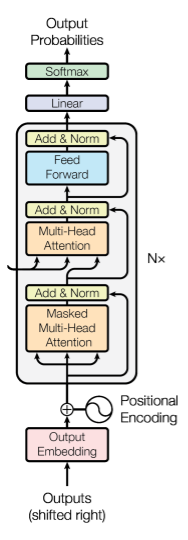

Let's turn this into code...

In [ ]:
class DecoderBlock(hk.Module):
    """The Transformer Decoder block, with cross-attention.

    This is the standard Transformer Decoder Block as implemented in any
    standard encoder-decoder Transformer.

    Args:
        d_model (int): The size of the embedding vector.
        num_heads (int): The number of attention heads.
        d_ff (int): The size of the hidden layer.
        p_dropout (float): The dropout probability.
        name (string): module name (default: None).
    """

    def __init__(self, d_model, num_heads, d_ff, p_dropout, name=None):
        super().__init__(name=name)
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.p_dropout = p_dropout

        # self-attention sub-layer
        self.self_attn = MultiheadAttention(
            d_model=self.d_model, num_heads=self.num_heads
        )
        # src-target cross-attention sub-layer
        self.cross_attn = MultiheadAttention(
            d_model=self.d_model, num_heads=self.num_heads
        )
        # positionwise feedforward sub-layer
        self.ff = PositionwiseFeedForward(
            d_model=self.d_model, d_ff=self.d_ff, p_dropout=self.p_dropout
        )
        self.norm1 = hk.LayerNorm(
            axis=-1, param_axis=-1, create_scale=True, create_offset=True
        )
        self.norm2 = hk.LayerNorm(
            axis=-1, param_axis=-1, create_scale=True, create_offset=True
        )
        self.norm3 = hk.LayerNorm(
            axis=-1, param_axis=-1, create_scale=True, create_offset=True
        )

    def __call__(self, x, memory, src_mask, tgt_mask, is_train):
        """
        Apply the encoder block to the input sequence.

        Args:
            x (jnp.ndarray): The input sequence with shape (batch_size, sequence_length, d_model).
            memory: (jnp.ndarray) The memory / output from the encoder
            src_mask: the mask for the src sequence.
            tgt_mask: the mask for the tgt sequence.
            is_train: boolean flag to indicate training mode.

        Returns:
            jnp.ndarray: The output of the decoder block, which is the updated input sequence with shape (batch_size, sequence_length, d_model).
        """

        # self-attention sub-layer
        sub_x, _ = self.self_attn(x, x, x, tgt_mask)
        if is_train:
            sub_x = hk.dropout(hk.next_rng_key(), self.p_dropout, sub_x)
        x = self.norm1(x + sub_x)  # residual conn

        # cross-attention sub-layer
        sub_x, _ = self.cross_attn(x, memory, memory, src_mask)
        if is_train:
            sub_x = hk.dropout(hk.next_rng_key(), self.p_dropout, sub_x)
        x = self.norm2(x + sub_x)

        # feedforward sub-layer
        sub_x = self.ff(x, is_train=is_train)
        if is_train:
            sub_x = hk.dropout(hk.next_rng_key(), self.p_dropout, sub_x)
        x = self.norm3(x + sub_x)

        return x

### [ 📝 ] Transformer Decoder

In [ ]:
class TransformerDecoder(hk.Module):
    """The Transformer Decoder with cross-attention.

    This is the standard Transformer Decoder, composed of multiple stacked
    Decoder Blocks as implemented in any standard encoder-decoder Transformer.

    Args:
        num_layers (int): The number of decoder layers.
        num_heads (int): The number of attention heads.
        d_model (int): The size of the embedding vector.
        d_ff (int): The size of the hidden layer.
        p_dropout (float): The dropout probability.
        name (str): The name of the module (default: None).
    """

    def __init__(self, num_layers, num_heads, d_model, d_ff, p_dropout, name=None):
        super().__init__(name=name)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_ff = d_ff
        self.p_dropout = p_dropout

        self.layers = [
            DecoderBlock(self.d_model, self.num_heads, self.d_ff, self.p_dropout)
            for _ in range(self.num_layers)
        ]

    def __call__(self, x, memory, src_mask, tgt_mask, is_train):
        """Transformer Decoder with cross-attention forward function.

        Args:
            x (jnp.ndarray): The input sequence with shape (batch_size, sequence_length, d_model).
            memory: (jnp.ndarray) The memory / output from the encoder.
            src_mask: the mask for the src sequence.
            tgt_mask: the mask for the tgt sequence
            is_train: boolean flag to indicate training mode.

        Returns:
            jnp.ndarray: The output of the decoder, which is the updated input sequence with shape (batch_size, sequence_length, d_model).
        """

        for l in self.layers:
            x = l(x, memory, src_mask, tgt_mask, is_train)
        return x

### [ 📝 ] The Transformer

and the transformer is finally what it should be:

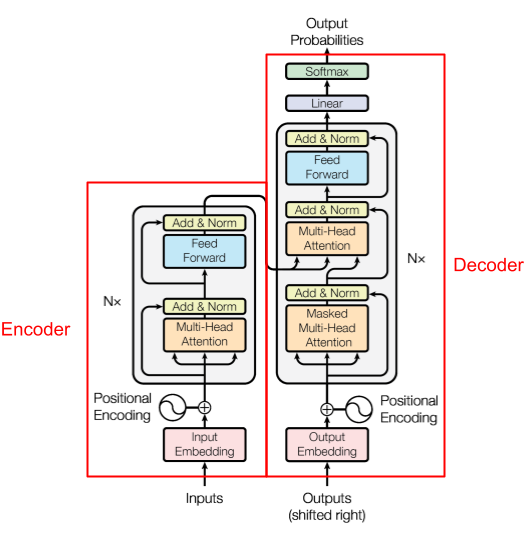

In [ ]:
class Transformer(hk.Module):
    """The encoder-decoder Transformer model.

    The Transformer model now contains the TransformerEncoder and the
    TransformerDecoder, with the Decoder cross-attending to the output of the
    Encoder.

    Args:
        d_model (int): The size of the embedding vector.
        d_ff (int): The size of the hidden layer.
        src_vocab_size (int): The size of the source vocabulary.
        tgt_vocab_size (int): The size of the target vocabulary.
        num_layers (int): The number of encoder and decoder layers.
        num_heads (int): The number of attention heads.
        p_dropout (float): The dropout probability.
        max_seq_len: maximum sequence length.
        tie_embeddings: should the source and the target share embeddings
    """
    def __init__(
        self,
        d_model,
        d_ff,
        src_vocab_size,
        tgt_vocab_size,
        num_layers,
        num_heads,
        p_dropout,
        max_seq_len,
        name=None,
        tie_embeddings=False,
    ):
        super().__init__(name)
        self.d_model = d_model
        self.d_ff = d_ff
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.p_dropout = p_dropout
        self.max_seq_len = max_seq_len

        self.src_emb = Embeddings(d_model, src_vocab_size)
        if tie_embeddings:
            self.tgt_emb = self.src_emb
        else:
            self.tgt_emb = Embeddings(d_model, tgt_vocab_size)
        # Encoder
        self.encoder = TransformerEncoder(
            num_layers, num_heads, d_model, d_ff, p_dropout
        )
        # Decoder
        self.decoder = TransformerDecoder(
            num_layers, num_heads, d_model, d_ff, p_dropout
        )

    def encode(self, src, src_mask, is_train):
        """Encoder forward pass.

        Args:
            src: the source sequence.
            src_mask: the mask for the src sequence.
            is_train: boolean flag to indicate training mode.
        Return:
            the encoded sequence.
        """
        ##################
        # YOUR CODE HERE #
        pe = PositionalEncoding(self.d_model, self.max_seq_len, self.p_dropout)
        src = self.src_emb(src)
        src = src[None, :, :] if len(src.shape) == 2 else src
        src = pe(src, is_train=is_train)
        # (i) embed the source
        # (ii) add the positional embedding
        ##################
        return self.encoder(src, src_mask, is_train)

    def decode(self, memory, src_mask, tgt, tgt_mask, is_train):
        """Decoder forward pass.

        Args:
            memory: the outpot of the encoder.
            src_mask: the mask for the src sequence.
            tgt: the target sequence.
            tgt_mask: the mask for the tgt sequence.
            is_train: boolean flag to indicate training mode.

        Returns:
            the output of the decoder.
        """
        ##################
        # YOUR CODE HERE #
        pe = PositionalEncoding(self.d_model, self.max_seq_len, self.p_dropout)
        tgt = self.tgt_emb(tgt)
        tgt = tgt[None, :, :] if len(tgt.shape) == 2 else tgt
        tgt = pe(tgt, is_train=is_train)
        # (i) embed the target
        # (ii) add the positional embedding
        ##################
        return self.decoder(tgt, memory, src_mask, tgt_mask, is_train)

    def __call__(self, src, src_mask, tgt, tgt_mask, is_train):
        """Transformer forward pass.

        Args:
            src: the source sequence.
            src_mask: the mask for the source sequence.
            tgt: the target sequence.
            tgt_mask: the mask for the target sequence.
            is_train: boolean flag to indicate whether the model is training.
        Returns:
            the output of the transformer model (encoder + decoder).
        """
        memory = self.encode(src, src_mask, is_train)
        return self.decode(memory, src_mask, tgt, tgt_mask, is_train)

## 3.4 Transformer for Neural Machine Translation

The original application of the Transformer was Neural Machine Translation (NMT, or MT). In this task, the network is presented with samples composed of a *source sentence* in a given language, say English, and a *target sentence* in a different language, say Greek, as the result of the translation. We will train an NMT system from scratch on the TatoEBA dataset.

Note that this section is heavily based on last year's colab.

With the Transformer class now ready, we can take our time to go through all the required steps in preparation for the actual training. As you have already seen earlier, we mainly need to:
1. pick a dataset. We need a parallel corpus, where each sample is made of a source and a target sentence;
2. train a tokenizer;
3. preprocess our corpus using the tokenizer.



## But...how?

How does this work? How do we train the transforer in a sequence-to-sequence setup, and how do we use it to transform a source into a target sequence? Let's cover these questions before turning to the actual code.

### How does it work?

The Transformer processes a source sequence producing a *contextualized, dense vector representation* of each token of the sequence. This step is exactly what you implemented with the Transformer Encoder.

At the same time, the model processes the target sequence with the Decoder. However, as opposed to the `SimpleTransformerDecoder` the Decoder now can't work in isolation - we need to inject the source sequence (its representation) and let the model learn a mapping between the source and the target sequences. This is exactly what you will implement in the remainder of this section.

### How do I train it?

We provide the model with both the source and target sequences at training time. The Encoder contextualizes the source tokens, and the Decoder **distills** this information in the target sequence representations, using a **cross-attention layer**. Additionally, each token in the Decoder is processed in an **autoregressive/masked** fashion, meaning that it expresses an attention weight only to previous/past tokens.

☝️ these *source distillation* and *autoregressive/masked attention* features are the two crucial differences between the Encoder and Decoder.

We've already seen the autoregressive/masked attention in the `SimpleTransformerDecoder` though so that shouldn't be news here...

### How do I use it to go from source to target?

Once it is trained, you have to "decode" the source sentence. You typically do that by:
1. encoding the source, as usual;
2. produce one token at a time. Each token will run self-attention on the past decoded tokens and cross-attention on the source sentence.

See the figure below for a graphical representation of decoding.

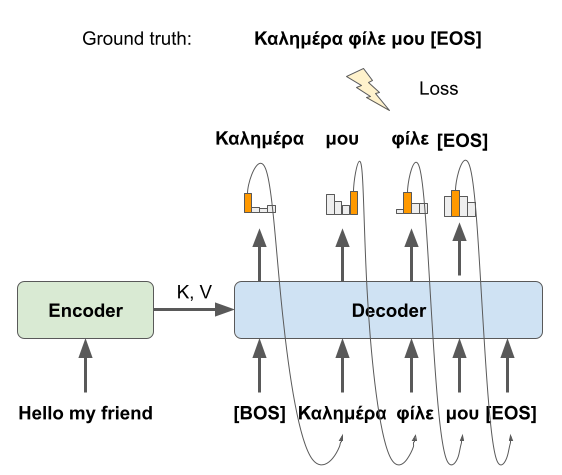


### Dataset selection

We will use a small and well-known TatoEBA dataset to train an English-to-Greek translation system. [TatoEBA](https://opus.nlpl.eu/Tatoeba.php) is a crowdsourced dataset of sentences annotated on the homonym [website](https://tatoeba.org/en/) by users. There are also other datasets, notably the [Europarl](https://www.statmt.org/europarl/) dataset, which is a corpus of proceedings of the European Parliament. You can see how to use this dataset in last year's colab.

We demonstrate the training and provide a few translation examples on TatoEBA since it is smaller and easier to train on.

### Training the tokenizer

Here, we opt for training a single tokenizer with double the number of tokens stored compared to the one used for language modeling.

Feel free to test your solution with two different tokenizers (one per language).

In [ ]:
# Target tokenizer (SRC+TGT language)
VOCAB_SIZE = 20_000

BATCH_SIZE = 128
NUM_LAYERS = 6
NUM_HEADS = 8
D_MODEL = 128
D_FF = 256
P_DROPOUT = 0.1
MAX_SEQ_LEN = 32        # lowered to speed up the training
LEARNING_RATE = 3e-4
GRAD_CLIP_VALUE = 1

In [ ]:
# Downloading and loading the TatoEBA dataset
# !curl -LO https://huggingface.co/morenolq/m2l_2022_nlp/resolve/main/it-en.tsv

mt_df = pd.read_csv(
    "el-en.tsv", sep="\t", header=0, names=["id_it", "sent_el", "id_en", "sent_en"]
)

In [ ]:
# we will use both english and greek sentences to generate our target tokenizer
el_sentences = mt_df["sent_el"].drop_duplicates().dropna()
en_sentences = mt_df["sent_en"].drop_duplicates().dropna()
print(f"Unique Greek sentences: {len(el_sentences)}")
print("Samples:\n", el_sentences[:5])

# we'll use BPE
mt_tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE(unk_token="[UNK]"))
mt_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()
mt_tokenizer.normalizer = tokenizers.normalizers.Lowercase()

trainer = tokenizers.trainers.BpeTrainer(
    special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"],
    vocab_size=VOCAB_SIZE,
    show_progress=True,
    min_frequency=2,
    continuing_subword_prefix="##",
)

mt_tokenizer.train_from_iterator(
    el_sentences.tolist() + en_sentences.tolist(), trainer=trainer
)

bos_id, eos_id = map(mt_tokenizer.token_to_id, ["[BOS]", "[EOS]"])
mt_tokenizer.post_processor = tokenizers.processors.BertProcessing(
    ("[EOS]", eos_id), ("[BOS]", bos_id)
)
mt_tokenizer.enable_truncation(MAX_SEQ_LEN)
mt_tokenizer.enable_padding(length=MAX_SEQ_LEN)

PAD_ID = mt_tokenizer.token_to_id("[PAD]")

Unique Greek sentences: 29443
Samples:
 0                                         Πάμε σινεμά;
1    Τα αγγλικά δεν είναι εύκολα, αλλά είναι ενδιαφ...
2                                            Δεν ξέρω.
4                          Κανείς δεν με καταλαβαίνει.
5                                     Δεν καταλαβαίνω.
Name: sent_el, dtype: object


### Preprocessing and tokenizing

We provide the code to run the basic dataset preprocessing. There is no need to peruse it, but feel free to inspect it to understand tokenisation better.

In [ ]:
# generate the train/valid/test splits

train_df_mt, test_df_mt = train_test_split(mt_df, test_size=0.2, random_state=42)
val_df_mt, test_df_mt = train_test_split(test_df_mt, test_size=0.5, random_state=42)
print("Train", train_df_mt.shape, "Valid", val_df_mt.shape, "Test", test_df_mt.shape)

raw_datasets = DatasetDict(
    {
        "train": Dataset.from_dict(
            {
                "sent_en": train_df_mt["sent_en"].tolist(),
                "sent_el": train_df_mt["sent_el"].tolist(),
            }
        ),
        "valid": Dataset.from_dict(
            {
                "sent_en": val_df_mt["sent_en"].tolist(),
                "sent_el": val_df_mt["sent_el"].tolist(),
            }
        ),
        "test": Dataset.from_dict(
            {
                "sent_en": test_df_mt["sent_en"].tolist(),
                "sent_el": test_df_mt["sent_el"].tolist(),
            }
        ),
    }
)


def preprocess(examples):
    src = mt_tokenizer.encode_batch(examples["sent_en"], add_special_tokens=False)
    tgt = mt_tokenizer.encode_batch(examples["sent_el"], add_special_tokens=True)

    return {
        "src_ids": [o.ids for o in src],
        "src_mask": [o.attention_mask for o in src],
        "src_special_tokens_mask": [o.special_tokens_mask for o in src],
        "tgt_ids": [o.ids for o in tgt],
    }


proc_datasets = raw_datasets.map(
    preprocess, batched=True, batch_size=4000, remove_columns=["sent_en", "sent_el"]
)

print("First training sample, after processing:", proc_datasets["train"][0])

Train (24583, 4) Valid (3073, 4) Test (3073, 4)


Map:   0%|          | 0/24583 [00:00<?, ? examples/s]

Map:   0%|          | 0/3073 [00:00<?, ? examples/s]

Map:   0%|          | 0/3073 [00:00<?, ? examples/s]

First training sample, after processing: {'src_ids': [38, 376, 8, 49, 482, 471, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'src_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'src_special_tokens_mask': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'tgt_ids': [2, 246, 309, 818, 13, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


### Utility functions and data structures

Let's define `collate_fn_mt` that collates the dataset into batches, making sure it creates jax arrays and deals with the masks appropriately (the two masks interact!)

In [ ]:
def collate_fn_mt(batch) -> dict:
    """Collate source and target sequences in the batch.

    We also need to define a 'labels' variable.

    You want to produce the following shapes:
    - src: (B,MAX_SEQ_LEN)
    - src_mask: (B,1,MAX_SEQ_LEN)
    - tgt: (B,MAX_SEQ_LEN-1)
    - tgt_mask: (B,MAX_SEQ_LEN-1,MAX_SEQ_LEN-1)
    - labels: (B,MAX_SEQ_LEN-1)
    """
    src = jnp.array([s["src_ids"] for s in batch])
    src_mask = jnp.array([s["src_mask"] for s in batch])
    src_mask = jnp.expand_dims(src_mask, 1)

    tgt_seq = jnp.array([s["tgt_ids"] for s in batch])
    tgt = tgt_seq[:, :-1]  # (B,MAX_SEQ_LEN-1)
    labels = tgt_seq[:, 1:]  # (B,MAX_SEQ_LEN-1)

    tgt_pad = jnp.where(jnp.expand_dims(tgt, axis=1) != PAD_ID, 1, 0)
    tgt_mask = jnp.where(tgt_pad & causal_mask(tgt.shape[-1]), 1, 0)

    item = {
        "src": src,
        "src_mask": src_mask,
        "tgt": tgt,
        "tgt_mask": tgt_mask,
        "labels": labels,
    }
    return item


train_loader_mt = DataLoader(
    proc_datasets["train"], batch_size=BATCH_SIZE, collate_fn=collate_fn_mt, shuffle=True
)
valid_loader_mt = DataLoader(
    proc_datasets["valid"], batch_size=BATCH_SIZE, collate_fn=collate_fn_mt
)
test_loader_mt = DataLoader(
    proc_datasets["test"], batch_size=BATCH_SIZE, collate_fn=collate_fn_mt
)

print(
    f"Batches Train: {len(train_loader_mt)}",
    f"Valid: {len(valid_loader_mt)}",
    f"Test : {len(test_loader_mt)}",
)

Batches Train: 193 Valid: 25 Test : 25


### Training the 🇬🇧 -> 🇬🇷 NMT Model!

#### [ 📝 ] Defining the model transformation

We can now define the Transformer model we will use to translate from English to Greek. We also define the loss function we can use to train the NMT model. Similarly to the Encoder model, we will use the cross-entropy loss, but we need to compute it across all target words (masking padding and all the words after the predicted token).

In [ ]:
@hk.transform
def mt_model(src, src_mask, tgt, tgt_mask, is_train=True):
    """The machine translation model that relies on the encoder and decoder defined above.

    Args:
        src: source sequences
        src_mask: source mask
        tgt: target sequences
        tgt_mask: target mask
        is_train: whether the model is in training mode or not
    Returns:
        logits
    """
    ##################
    # YOUR CODE HERE #
    model = Transformer(
        d_model=D_MODEL,
        d_ff=D_FF,
        src_vocab_size=VOCAB_SIZE,
        tgt_vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        p_dropout=P_DROPOUT,
        max_seq_len=MAX_SEQ_LEN,
        tie_embeddings=True,
    )

    output_embs = model(src, src_mask, tgt, tgt_mask, is_train=is_train)

    # final decoder
    out = hk.Linear(VOCAB_SIZE, name="decoder_final_linear")(output_embs)  # logits
    # out = jax.nn.log_softmax(out)
    # (i) instantiate the transformer model
    # (ii) pass the inputs through it
    # (iii) add a linear layer to the output
    ##################
    return out

In [ ]:
def prepare_sample(tokenizer, src_text, tgt_text=None, max_seq_len=MAX_SEQ_LEN):
    """Prepare a sample for the model.

    This function encode the source and target sequences to generate the
    sentence pair. It also generates the attention masks for the source
    and target sequences.

    Args:
        tokenizer: the tokenizer to use
        src_text: the source text
        tgt_text: the target text
        max_seq_len: the maximum sequence length
    Returns:
        a tuple of (src_enc, src_mask, tgt_enc, tgt_mask) if tgt_text is not None, otherwise (src_enc, src_mask)
    """

    src_enc = tokenizer.encode(src_text, add_special_tokens=False)
    src = jnp.array([src_enc.ids])
    src_mask = jnp.expand_dims(jnp.array([src_enc.attention_mask]), 1)

    item = (src, src_mask)

    if tgt_text is not None:
        tgt_enc = tokenizer.encode(tgt_text, add_special_tokens=True)
        tgt = jnp.array([tgt_enc.ids])
        tgt_mask = causal_mask(max_seq_len)
        item += (tgt, tgt_mask)

    return item

In [ ]:
# testing the MT model
src, src_mask, tgt, tgt_mask = prepare_sample(
    mt_tokenizer, "Hello my friend", "Καλημέρα φίλε μου"
)

rng_key = next(rng_iter)
params = mt_model.init(rng_key, src, src_mask, tgt, tgt_mask, True)
logits = mt_model.apply(
    params,
    rng=rng_key,
    src=src,
    src_mask=src_mask,
    tgt=tgt,
    tgt_mask=tgt_mask,
    is_train=False,
)
print("Logits shape", logits.shape)

Logits shape (1, 32, 20000)


In [ ]:
# testing loss functions
counter = 0
for batch in train_loader_mt:
    out = mt_model.apply(
        params=params,
        rng=rng_key,
        src=batch["src"],
        src_mask=batch["src_mask"],
        tgt=batch["tgt"],
        tgt_mask=batch["tgt_mask"],
        is_train=True,
    )

    labels = batch["labels"]
    loss = optax.softmax_cross_entropy_with_integer_labels(out, labels)
    loss = jnp.where(labels != PAD_ID, loss, 0.0)
    not_pad_count = (labels != PAD_ID).sum()

    print(loss.sum() / not_pad_count)

    if counter >= 1:
        break
    else:
        counter += 1

10.45689
10.398707


#### [ 📝 ] Setup the training loop

In [ ]:
EPOCHS = 5  # @param {type:"number"}
EVAL_STEPS = 500  # @param {type:"number"}
LOG_STEPS = 200

In [ ]:
## @title Initialise network and optimiser; note we draw an input to get shapes.
sample = proc_datasets["train"][0]
src, src_mask, tgt = map(
    jnp.array,
    (
        sample["src_ids"],
        sample["src_mask"],
        sample["tgt_ids"],
    ),
)
tgt_mask = causal_mask(MAX_SEQ_LEN)

rng_key = next(rng_iter)
init_params = mt_model.init(rng_key, src, src_mask, tgt, tgt_mask, True)

# We could use learning rate scheduling / annealing
# total_steps = EPOCHS * len(train_loader_mt)
# schedule = optax.warmup_cosine_decay_schedule(
#     init_value=1e-6,
#     peak_value=LEARNING_RATE,
#     warmup_steps=int(0.1 * total_steps),
#     decay_steps=total_steps,
#     end_value=1e-6,
# )
optimizer = optax.chain(
    optax.clip_by_global_norm(GRAD_CLIP_VALUE),
    optax.adam(learning_rate=LEARNING_RATE),
)
init_opt_state = optimizer.init(init_params)

In [ ]:
def loss_fn_mt(params: hk.Params, batch, rng) -> jnp.ndarray:
    """The loss function for the machine translation model.

    The loss is computed as the sum of the cross entropy loss for each token
    in the target sequence.

    Args:
        params: the model parameters
        batch: the batch of data
        rng: the random number generator
    Returns:
        the loss value
    """

    ##################
    # YOUR CODE HERE #
    logits = mt_model.apply(
        params=params,
        rng=rng,
        src=batch["src"],
        src_mask=batch["src_mask"],
        tgt=batch["tgt"],
        tgt_mask=batch["tgt_mask"],
        is_train=True,
    )

    labels = batch["labels"]
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    loss = jnp.where(labels != PAD_ID, loss, 0.0)
    not_pad_count = (labels != PAD_ID).sum()
    # (i) run the mt_model
    # (ii) use optax.softmax_cross_entropy_with_integer_labels for the loss
    # (iii) mask the loss to be 0 on padded elements
    # (iv) count the patted elements into not_pad_count so we can correctly average
    ##################
    return loss.sum() / not_pad_count


@jax.jit
def train_step_mt(params, opt_state, batch, rng_key):
    """The training step for the machine translation model.

    Args:
        params: model params
        opt_state: the state of the optimizer
        batch: the batch of data
        rng_key: the random number generator
    Returns:
        the new params, opt_state, the metrics (training loss)
        and the random number generator
    """
    rng_key, rng = jax.random.split(rng_key)

    loss_and_grad_fn = jax.value_and_grad(loss_fn_mt)
    loss, grads = loss_and_grad_fn(params, batch, rng_key)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    metrics = {"train_loss": loss}

    return params, opt_state, metrics, rng_key


@jax.jit
def deterministic_forward(
    params: hk.Params, src, src_mask, tgt, tgt_mask
) -> jnp.ndarray:
    """The deterministic forward pass for the machine translation model.

    It leverages without_apply_rng to avoid the need for a random number generator.

    Args:
        params: the model parameters
        src: the source sequences
        src_mask: the source mask
        tgt: the target sequences
        tgt_mask: the target mask

    Returns:
        the logits
    """
    return hk.without_apply_rng(mt_model).apply(
        params=params,
        is_train=False,
        src=src,
        src_mask=src_mask,
        tgt=tgt,
        tgt_mask=tgt_mask,
    )


@jax.jit
def eval_step_mt(params: hk.Params, batch) -> jnp.ndarray:
    """The evaluation step for the machine translation model.

    Args:
        params: the model parameters
        batch: the batch of data
    Returns:
        the evaluation loss
    """
    logits = deterministic_forward(
        params, batch["src"], batch["src_mask"], batch["tgt"], batch["tgt_mask"]
    )
    labels = batch["labels"]

    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    loss = jnp.where(labels != PAD_ID, loss, 0.0)
    not_pad_count = (labels != PAD_ID).sum()
    return loss.sum() / not_pad_count

#### Training and evaluation loop

In [ ]:
EPOCHS = 1
EVAL_STEPS = 100

In [ ]:
pbar = tqdm(desc="Train step", total=EPOCHS * len(train_loader_mt))
step = 0
loop_metrics = {"train_loss": None, "eval_loss": None}
best_eval_loss = float("inf")
losses = []
params, opt_state = init_params, init_opt_state
for epoch in range(EPOCHS):

    for batch in train_loader_mt:

        params, opt_state, metrics, rng_key = train_step_mt(
            params, opt_state, batch, rng_key)
        losses.append(metrics['train_loss'])
        loop_metrics.update(metrics)
        pbar.update(1)
        step += 1

        if step % EVAL_STEPS == 0:
            ebar = tqdm(desc="Eval step", total=len(valid_loader_mt), leave=False)

            losses = list()
            for batch in valid_loader_mt:
                loss = eval_step_mt(params, batch)
                losses.append(loss)
                ebar.update(1)
            ebar.close()

            eval_loss = jnp.array(losses).mean()
            loop_metrics["eval_loss"] = eval_loss

            # writer.add_scalar("Loss/valid", loop_metrics["eval_loss"].item(), step)

            if eval_loss.item() < best_eval_loss:
                best_eval_loss = eval_loss.item()
                # Save the params training state (and params) to disk
                with open(f"mt_train_state_{step}.pkl", "wb") as fp:
                    pickle.dump((params, opt_state), fp)

        # if step % LOG_STEPS == 0:
        #     writer.add_scalar("Loss/train", loop_metrics["train_loss"].item(), step)
        #     writer.add_scalar("lr/train", schedule(step).item(), step)
        #     writer.add_scalar("epoch/train", epoch, step)

        pbar.set_postfix(loop_metrics)

pbar.close()

Train step:   0%|          | 0/193 [00:00<?, ?it/s]

Eval step:   0%|          | 0/25 [00:00<?, ?it/s]

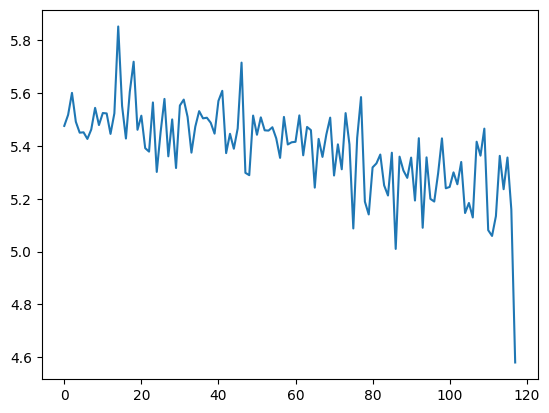

In [ ]:
plt.plot(losses)

#### [ 📝 ] Greedy Decoding

We iteratively process the sequence through the encoder to generate the output sequence. Specifically, we will use **greedy decoding**: we take the token with the highest log-likelihood (logit) at each step to generate the complete output sequence.

Decoding strategies are a broad research topic that we are touching only on the most naive approach. For a basic introduction to other generation strategies, please refer to [this blog post](https://huggingface.co/blog/how-to-generate).

In [ ]:
def translate(params, query, tokenizer, show_progress=False):
    """Translate a query using the machine translation model.

    This function uses the greedy decoding strategy.

    Args:
        params: the model parameters
        query: the query to translate
        tokenizer: the tokenizer
        show_progress: whether to show the progress of the translation
    Returns:
        the translated query
    """

    ##################
    # YOUR CODE HERE #
    model = hk.without_apply_rng(mt_model)
    src, src_mask = prepare_sample(src_text=query, tokenizer=tokenizer)

    tgt = jnp.full((1, 1), tokenizer.token_to_id("[BOS]"), dtype=src.dtype)

    for i in tqdm(range(MAX_SEQ_LEN - 1), desc="Decoding", disable=not show_progress):
        logits = deterministic_forward(
            params, src, src_mask, tgt, causal_mask(tgt.shape[1])
        )
        next_word = logits[0, i, :].argmax()
        tgt = jnp.concatenate(
            [tgt, jnp.full((1, 1), next_word, dtype=src.dtype)], axis=-1
        )
        if next_word == tokenizer.token_to_id("[EOS]"):
            break
    # (i) run the mt_model without the rng
    # (ii) prepare the source sample
    # (iii) set up the first token in the target to be [BOS]
    # (iv) iterate through:
    #  (v) run the deterministic_forward
    #  (vi) take the argmax of the last output
    #  (vii) concatenate the output to the target
    #  (viii) if the generated next word is [EOS], stop the process
    #  (ix) go back to (iv)
    ##################
    return tokenizer.decode(tgt[0]).replace(" ##", "")

In [ ]:
query = "They played well."
tgt = translate(params, query, mt_tokenizer, show_progress=True)
tgt

Decoding:   0%|          | 0/31 [00:00<?, ?it/s]

'δεν είναι .'

Note again that one needs to train the model for a fairly large number of steps to start getting meaningful outputs.